In [58]:
import os
import pickle

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import tensorflow as tf
import madmom

from segment import segment_spectrogram
from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor
from datasets import Dataset
from analyze_detection import evaluate, f_score

%load_ext autoreload
%autoreload 2

SR = 44100
HOP = 441
CONTEXT = 7


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
# Load Madmom normalization
def cnn_normalize(frames):
    inv_std = np.load("models/bock2013pret_inv_std.npy")
    mean = np.load("models/bock2013pret_mean.npy")
    frames_normalized = (frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
    return frames_normalized
    
# Load preprocessing funciton
preprocessor = cnn_preprocessor()
box_processor = madmom.features.onsets.CNNOnsetProcessor()

In [82]:
ds = Dataset("holzap_dev", annotation_format="onsets")
audio_fnames = ds.get_audio_paths()
label_fnames = ds.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [genfromtxt(label_fname, delimiter=',') for label_fname in label_fnames]
for ele in sample_rates:
    if ele != SR:
        print("Some sample rates are not equal to 44.1kHz!")

Dataset created
Found 21 audio files and 21 annotation files.


/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [220]:
# Prepare onsets
onset_vectors = [get_label_vector(sched, len(audio)/SR, HOP, SR)
    for (sched, audio) in zip(onset_schedules, audios)
]
print(onset_vectors[0].shape)

(1500,)


In [190]:
with open("models/bock2013pret-tf.pkl", 'rb') as handle:
    base_model = pickle.load(handle)

In [221]:
# Create data and normalize
mm_proc_frames = [preprocessor(fname) for fname in audio_fnames]
mm_frames_normalized = [cnn_normalize(frame_set) for frame_set in mm_proc_frames]
print(mm_frames_normalized[0].shape)
X_test = [[
    data[i-CONTEXT:i+CONTEXT+1,:,:] 
    for i in range(CONTEXT, data.shape[0]-CONTEXT)
] for data in mm_frames_normalized]
X_test = [np.transpose(np.stack(data, 0), [0,2,1,3]) for data in X_test]
print(X_test[0].shape)

/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


(1514, 80, 3)
(1500, 80, 15, 3)


In [222]:
activation_fns = [base_model.predict(input) for input in X_test]

In [217]:
activation_fns = [box_processor(fname) for fname in audio_fnames]
print(activation_fns[0].shape)

(1500,)


In [226]:
THRES = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]
TOL = 0.05
KERNEL_SIZE = 5
N_PRE = 5
N_POST = 1
F_RATE = HOP/SR #feature rate

peaks = [[madmom.features.onsets.peak_picking(
                                            activations=act_fn, 
                                            threshold=th, 
                                            smooth=KERNEL_SIZE, 
                                            pre_avg=N_PRE, 
                                            post_avg=N_POST, 
                                            pre_max=N_PRE, 
                                            post_max=N_POST
)[0].astype(np.float32)*F_RATE for th in THRES] for act_fn in activation_fns]
print(peaks[0][0])


[ 0.08        0.26999998  0.34        0.45999998  0.61        0.79999995
  0.95        1.02        1.11        1.1899999   1.24        1.3299999
  1.54        1.75        1.8199999   1.9         2.09        2.22
  2.34        2.55        3.8899999   3.9499998   4.16        4.54
  4.8199997   4.93        5.0299997   5.1099997   5.24        5.43
  5.6099997   5.64        5.71        5.7599998   5.87        5.94
  6.31        6.54        6.6099997   6.97        7.18        7.25
  7.31        7.37        7.79        8.07        8.32        8.49
  8.87        8.99        9.05        9.73       10.         10.139999
 10.42       10.5        10.58       10.76       10.87       10.95
 11.059999   11.11       11.219999   11.4        11.99       12.559999
 12.84       12.95       13.         13.24       13.29       13.4
 13.46       13.62       13.86       13.98       14.16       14.299999
 14.61      ]


In [227]:
metrics = [[evaluate(
    onsets_pred,
    onsets_true,
    TOL
) for onsets_pred in peaks] for peaks, onsets_true in zip(peaks, onset_schedules)] 

In [213]:
print("Threshold: {}    Time tolerance: {}".format(THRES, TOL))
for metric, name in zip(metrics, audio_fnames):
    print("Name: {}".format(name))
    for t, m in zip(THRES, metric):
        print("Threshold: {}    Precision: {:.1f}".format(t, 100*m[0]/(m[0]+m[2])) + "    " +
                "Recall: {:.1f}".format(100*m[0]/(m[0]+m[1]))
        )

Threshold: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]    Time tolerance: 0.025
Name: datasets/OnsetLabeledInstr2013/development/Piano/piano1.wav
Threshold: 0.001    Precision: 95.2    Recall: 41.7
Threshold: 0.002    Precision: 95.2    Recall: 55.6
Threshold: 0.005    Precision: 95.2    Recall: 80.0
Threshold: 0.01    Precision: 95.2    Recall: 95.2
Threshold: 0.02    Precision: 95.2    Recall: 100.0
Threshold: 0.05    Precision: 95.2    Recall: 100.0
Threshold: 0.1    Precision: 95.2    Recall: 100.0
Threshold: 0.2    Precision: 95.2    Recall: 100.0
Threshold: 0.5    Precision: 95.2    Recall: 100.0
Threshold: 0.9    Precision: 90.5    Recall: 100.0
Name: datasets/OnsetLabeledInstr2013/development/Piano/mussorgsky.wav
Threshold: 0.001    Precision: 100.0    Recall: 76.5
Threshold: 0.002    Precision: 100.0    Recall: 86.7
Threshold: 0.005    Precision: 100.0    Recall: 86.7
Threshold: 0.01    Precision: 100.0    Recall: 92.9
Threshold: 0.02    Precision: 100.0    Rec

23551

Threshold: 0.001    Precision: 88.9    Recall: 38.7    F-measure: 54.0
Threshold: 0.002    Precision: 88.9    Recall: 41.7    F-measure: 56.7
Threshold: 0.005    Precision: 88.6    Recall: 46.8    F-measure: 61.3
Threshold: 0.01    Precision: 87.8    Recall: 50.7    F-measure: 64.3
Threshold: 0.02    Precision: 82.7    Recall: 55.5    F-measure: 66.4
Threshold: 0.05    Precision: 71.8    Recall: 65.0    F-measure: 68.2
Threshold: 0.1    Precision: 58.7    Recall: 75.9    F-measure: 66.2
Threshold: 0.2    Precision: 47.4    Recall: 88.5    F-measure: 61.7
Threshold: 0.5    Precision: 43.1    Recall: 100.0    F-measure: 60.3
Threshold: 0.9    Precision: 42.8    Recall: 100.0    F-measure: 59.9


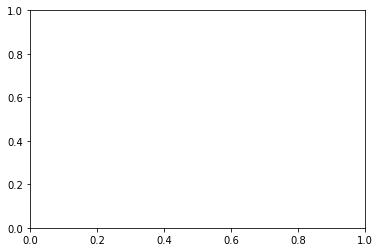

In [228]:
fig, ax =plt.subplots()
ax.set_xlim([0,1])
ax.set_ylim([0,1])

for t in range(len(metrics[0])):
    TP_TOT = np.sum([metric[t][0] for metric in metrics])
    FN_TOT = np.sum([metric[t][1] for metric in metrics])
    FP_TOT = np.sum([metric[t][2] for metric in metrics])
    N = np.sum([np.sum(v==0) for v in onset_vectors])
    TN_TOT = N-FN_TOT
    print("Threshold: {}    Precision: {:.1f}".format(THRES[t], 100*CD_TOT/(CD_TOT+FP_TOT)) + "    " +
            "Recall: {:.1f}".format(100*CD_TOT/(CD_TOT+FN_TOT)) + "    " + 
            "F-measure: {:.1f}".format(200*CD_TOT/(2*CD_TOT+FP_TOT+FN_TOT))
    )
    #ax.scatter(FP_TOT/(FP_TOT+TN_TOT), TP_TOT/(TP_TOT+FN_TOT), c='brown')



60564.552902900556

In [70]:
data = np.transpose(mm_spects, axes=[0,2,1,3])
normalized_data = (data - mean_resh)*inv_std_resh
normalized_data.sum()

905996.303575408

In [58]:
# Load model
with open("models/bock2013pret-tf.pkl", 'rb') as handle:
    model =pickle.load(handle)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 15, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 26, 10)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 8, 20)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1120)              0

In [71]:
intermediate = tf.keras.Model(model.input, outputs=model.get_layer('conv2d').output)

intermediate.predict(normalized_data).sum()

-3977391.2

(1041,)


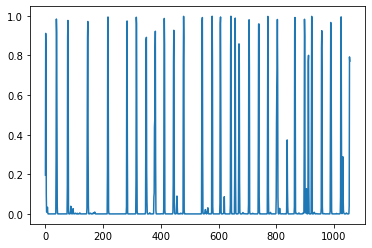

In [66]:
CONTEXT = 7
madmom_act_fn = np.load("results/madmomCNNOnsetProcessor/42954_FreqMan_hoochie_violin_pt1.npy")
print(madmom_act_fn[CONTEXT:-CONTEXT-1].shape)
plt.plot(madmom_act_fn)

NameError: name 'onset_vectors' is not defined

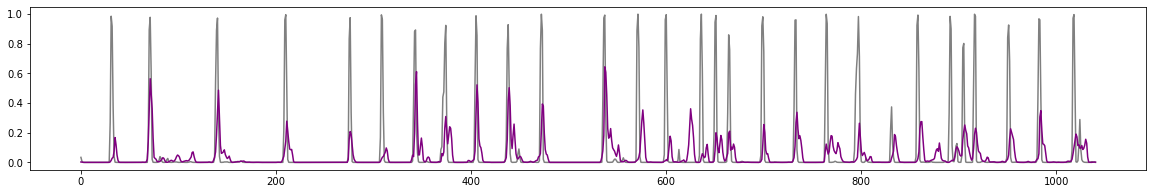

In [69]:
#pred_function = model.predict(normalized_data).reshape((-1))
#smoothed_pred_function = np.convolve(pred_function, np.hamming(7), mode='same')
plt.figure(figsize=(20,3))
plt.plot(madmom_act_fn[CONTEXT:-CONTEXT-1], c='gray')
plt.plot(debug_pred[CONTEXT:-CONTEXT-1], c='purple')
onset_idx = np.where(onset_vectors[0]==1)[0]
plt.scatter(onset_idx, np.zeros_like(onset_idx) + .5, marker='x', c='r' )
plt.legend(["Black-box detection function", "Implemented detection function (kernel size=5)", "Annotated onsets"])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_1 (Permute)         (None, 15, 80, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 26, 10)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 8, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1120)             

In [32]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    class_weight = {0: 1., 1: 1/0.035},
    epochs = 10,
    batch_size = 256
)

Epoch 1/10
177/177 [==============================] - 59s 293ms/step - loss: 0.1448 - fp01: 994.0000 - fn01: 39568.0000 - fp05: 2.0000 - fn05: 40560.0000 - val_loss: 0.0744 - val_fp01: 244.0000 - val_fn01: 11994.0000 - val_fp05: 0.0000e+00 - val_fn05: 12238.0000
Epoch 2/10
177/177 [==============================] - 35s 198ms/step - loss: 0.1116 - fp01: 1709.0000 - fn01: 38853.0000 - fp05: 5.0000 - fn05: 40557.0000 - val_loss: 0.0674 - val_fp01: 330.0000 - val_fn01: 11908.0000 - val_fp05: 0.0000e+00 - val_fn05: 12238.0000
Epoch 3/10
177/177 [==============================] - 46s 260ms/step - loss: 0.1031 - fp01: 1781.0000 - fn01: 38781.0000 - fp05: 6.0000 - fn05: 40556.0000 - val_loss: 0.0638 - val_fp01: 269.0000 - val_fn01: 11969.0000 - val_fp05: 1.0000 - val_fn05: 12237.0000
Epoch 4/10
177/177 [==============================] - 41s 230ms/step - loss: 0.0994 - fp01: 1801.0000 - fn01: 38761.0000 - fp05: 2.0000 - fn05: 40560.0000 - val_loss: 0.0624 - val_fp01: 377.0000 - val_fn01: 11861.

KeyboardInterrupt: 

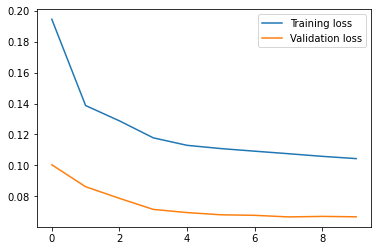

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss", "Validation loss"])

ZeroDivisionError: float division by zero

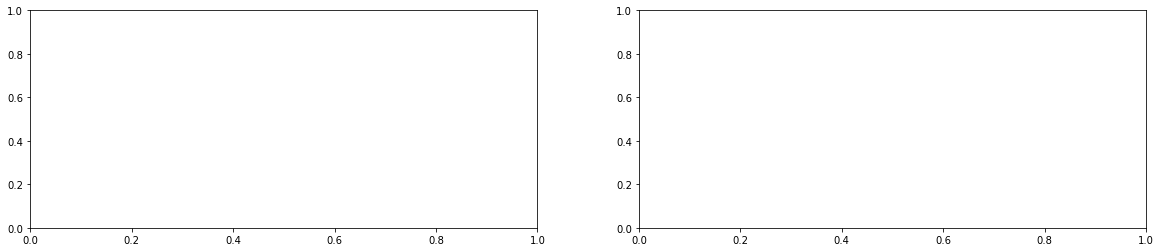

In [13]:
fig, axs = plt.subplots(1,2,figsize=(20,4))
# Prec. training
axs[0].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['tp'], history.history['fp'])], color='lightblue')
# Rec. training
axs[0].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['tp'], history.history['fn'])], color='lightgreen')
# F-measure
axs[0].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['tp'], history.history['fp'], history.history['fn'])], 'k:')
axs[0].legend(["Precision", "Recall", "F-measure"])

# Prec. training
axs[1].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['val_tp'], history.history['val_fp'])], color='lightblue')
# Rec. training
axs[1].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['val_tp'], history.history['val_fn'])], color='lightgreen')
# F-measure
axs[1].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['val_tp'], history.history['val_fp'], history.history['val_fn'])], 'k:')
axs[1].legend(["Precision", "Recall", "F-measure"])

In [ ]:
training_name = "3787-nofuzz-100eps"
with open('results/cnn-training-220316/{}.pickle'.format(training_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [14]:
model.evaluate(X_test, y_test)


113/113 [==============================] - 1s 9ms/step - loss: 0.0538 - tp: 0.0000e+00 - fp: 0.0000e+00 - fn: 3475.0000 - f1: 0.0000e+00


[0.053785886615514755, 0.0, 0.0, 3475.0, 0.0]

## Audio analysis and onset extraction

In [15]:
test_index = split_idx[-n_test:][0]
audio = tfio.audio.AudioIOTensor('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index))
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)
print("Test recording: ", test_index)

Test recording:  10


In [16]:
with open('datasets/initslurtest_vn/spectrogram/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    spects=pickle.load(handle)


In [17]:
onset_times = genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index), delimiter=',')
times = np.arange(0, len(audio_tensor)/44100, 440/44100)
labels = get_label_vector(times, onset_times, fuzzy=False)
print("Number of true onsets: ", len(onset_times))

Number of true onsets:  52


In [18]:
with open('datasets/initslurtest_vn/frames/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    frames=pickle.load(handle)
print(frames.shape)

(4020, 80, 15, 3)


Onsets detected:  52


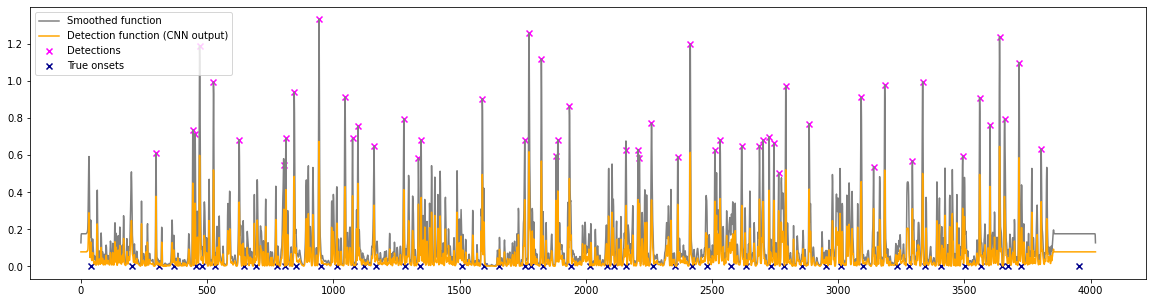

In [21]:
from scipy.signal import find_peaks
from librosa.util import peak_pick

kernel_size = 5
threshold = 0.3

pred_onsets = model.predict(frames)[:,0]
plt.figure(figsize=(20,5))

smoothed = np.convolve(pred_onsets, np.hamming(kernel_size), mode='same')
plt.plot(smoothed, c='gray')
plt.plot(pred_onsets, c='orange')

peaks, _ = find_peaks(pred_onsets, height=threshold)
print("Onsets detected: ", len(peaks))
plt.scatter(peaks, smoothed[peaks], c='magenta', marker='x')

plt.scatter(onset_times*sr/HOP, np.zeros_like(onset_times), marker='x', c='darkblue')
plt.legend(["Smoothed function", "Detection function (CNN output)", "Detections", "True onsets"])
plt.show()

In [22]:
from analyze_detection import evaluate

true = onset_times
pred = peaks*HOP/sr

[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=0.25)

print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))

Precision: 58.2 %
Recall: 61.5 %


In [ ]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()